# Introduction

In the first portion of this assignment 3 walkthrough, we rely on a popular NLP library [spaCy](https://spacy.io/) to create knowledge graphs.

In order to do this, we use the gramatical rules about sentence composition encoded in spaCy.

We begin by downloading the English lexicon.


In [1]:
! python -m spacy download en_core_web_lg

2022-10-25 15:07:05.177923: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 18 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


We will use the [networkx](https://networkx.org/) library to plot the knowledge graphs created for the movie reviews. 

In [2]:
import spacy

import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from spacy.matcher import Matcher 

from tqdm import tqdm

In [3]:
sns.set_context('talk')

In [4]:
# Sometimes the path of the downloaded spacy model doesn't get picked on Colab
# This cell needs to be executed in such situations
# Use this only if spacy.load(...) is failing in the next step

import spacy.cli

spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [5]:
nlp = spacy.load('en_core_web_lg')

# Data

In [6]:
class_corpus = pd.read_csv('/content/DSP453_ClassCorpus_v1.csv')

In [7]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Doc_ID                    100 non-null    int64 
 1   DSI_Title                 100 non-null    object
 2   Text                      100 non-null    object
 3   Submission File Name      100 non-null    object
 4   Student Name              100 non-null    object
 5   Genre of Movie            100 non-null    object
 6   Review Type (pos or neg)  100 non-null    object
 7   Movie Title               100 non-null    object
dtypes: int64(1), object(7)
memory usage: 6.4+ KB


In [8]:
class_corpus.Text.head()

0    "Holmes and Watson review: a lumbering Sherloc...
1    "ï¿½Holmes & Watsonï¿½ Review: No, Sh-t Sherlo...
2    "It is often said that Sherlock Holmes, the le...
3    "Holmes & Watson wasnï¿½t shown at all to the ...
4    "ï¿½Holmes & Watsonï¿½ Review: Will Ferrell an...
Name: Text, dtype: object

In [9]:
class_corpus['Movie Title'].value_counts()

Holmes and Watson    10
Dirty Grandpa        10
No Time to Die       10
Taxi                 10
Taken                10
It Chapter Two       10
The toxic avenger    10
Us                   10
Equilibrium          10
Oblivion             10
Name: Movie Title, dtype: int64

Creation of knowledge graphs rests on two crucial ingredients.  
- entities that represent specific concepts
- relations that connect different concepts

Translated into the rules of English, [the hypothesis](https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook) is that for each sentence:
 - entities are the subject and object in the sentence
 - verbs encode the relation between the entities in the sentence
 - entities could be compound words (e.g., phrases)  

In [10]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " " + tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " " + tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier + " " + prefix + " " + tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier + " " + prefix + " " + tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                   {'DEP':'prep', 'OP':"?"},
                   {'DEP':'agent', 'OP':"?"},  
                   {'POS':'ADJ', 'OP':"?"}] 
        
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except Exception as e:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

As the above code listing indicates, we use spaCy's grammatical annotations for the tokens (indicated by `dep_`) to identify the relevant parts of speech.

In [11]:
spacy.explain('agent')

'agent'

For this part of the assignment, we work on a set of reviews for one movie.

In [12]:
MOVIE_TO_EXPLORE = 'Taxi'

In [13]:
movie_reviews = (class_corpus.loc[class_corpus['Movie Title'] == MOVIE_TO_EXPLORE, 'Text']
                             .reset_index(drop=True))

# Example Review

Let us see how the entity and relation functions work on an example sentence from the set of 10 reviews.

## Explore entities & relations

In [14]:
movie_reviews

0    "Bringing Down the House notwithstanding, Quee...
1    "After getting nominated for ""Chicago"" and m...
2    "Hollywood certainly does not, testament to th...
3    "How one likes ""Taxi"" has everything to do w...
4    "One of my favorite comedies to watch during t...
5    "Washburn is an undercover cop who, after yet ...
6    "Jimmy Fallon's big screen career may be over ...
7    "Gï¿½rard Pirï¿½s' 1998 film Taxi seems to hav...
8    "I'm actually old enough that when I hear the ...
9    "Queen Latifah handily walked away with the sh...
Name: Text, dtype: object

In [15]:
movie_reviews[1]

'"After getting nominated for ""Chicago"" and making a box-office splash with ""Bringing Down the House"" a year and a half ago, the sun was shining hot for Queen Latifah. She then turned up in a few films (Scary Movie 3, Barbershop 2, and The Cookout, which she also produced) in cameo roles. Now she\'s back in a star vehicle along with a comedian ready to break out on his own. Jimmy Fallon has been known to many as a member of NBC\'s Saturday Night Live and now he\'s starring with a well known actor/comedian/singer. Together, the two of them star in ""Taxi"", a film that has plenty of action, laughs, and sex appeal. While the film has the look of a clichï¿½ buddy movie, Latifah and Fallon bring in their own flair of comedic skills to make a difference and take you on a New York joyride. Set in New York City, Belle (Queen Latifah) is a speed freak, in the vehicle sense. Initially a bike messenger, she takes pride in that she can run her errands in record fashion. When her time comes, s

In [16]:
doc = nlp(movie_reviews[1])

Passing a review through the `nlp` pipeline from `spaCy` automatically generates a set of sentences in the review. This is accessed by the attribute `sents`.

In [17]:
list(doc.sents)

["After getting nominated for ""Chicago"" and making a box-office splash with ""Bringing Down the House"" a year and a half ago, the sun was shining hot for Queen Latifah.,
 She then turned up in a few films (Scary Movie 3, Barbershop 2, and The Cookout, which she also produced) in cameo roles.,
 Now she's back in a star vehicle along with a comedian ready to break out on his own.,
 Jimmy Fallon has been known to many as a member of NBC's Saturday Night Live,
 and now he's starring with a well known actor/comedian/singer.,
 Together, the two of them star in ""Taxi"", a film that has plenty of action, laughs, and sex appeal.,
 While the film has the look of a clichï¿½ buddy movie, Latifah and Fallon bring in their own flair of comedic skills to make a difference and take you on a New York joyride.,
 Set in New York City, Belle (Queen Latifah) is a speed freak, in the vehicle sense.,
 Initially a bike messenger, she takes pride in that she can run her errands in record fashion.,
 When he

In [18]:
doc_sents = [str(x) for x in list(doc.sents)]

Let us pick the first sentence to observe how the entity-relation extraction works.

In [19]:
example_sent = doc_sents[0]

In [20]:
example_sent

'"After getting nominated for ""Chicago"" and making a box-office splash with ""Bringing Down the House"" a year and a half ago, the sun was shining hot for Queen Latifah.'

Vanilla application of the `get_subject_verb_object` function does not yield a good result since theer could be compound entities.

In [21]:
get_subject_verb_object(example_sent)

['sun', 'shining', 'House']

Passing the example sentence to the `nlp` pipeline extracts the parts of speech in the sentence.

In [22]:
example_nlp = nlp(example_sent)

In [23]:
for tok in example_nlp:
    print(tok.dep_)

punct
prep
auxpass
pcomp
prep
punct
punct
pobj
punct
punct
cc
conj
det
compound
punct
compound
dobj
prep
punct
punct
pcomp
prt
det
dobj
punct
punct
det
npadvmod
cc
quantmod
conj
advmod
punct
det
nsubj
aux
ROOT
oprd
prep
compound
pobj
punct


In [56]:
spacy.explain('punct')

'punctuation'

In [25]:
get_entities(example_sent)

['ago box office sun', 'Queen Latifah']

In [26]:
get_relation(example_sent)

'shining hot'

We can now parse through all the sentences in the review and extract the entities and relations.

In [27]:
entity_pairs = []

for i in tqdm(doc_sents):
  entity_pairs.append(get_entities(i))

100%|██████████| 34/34 [00:00<00:00, 118.71it/s]


In [28]:
entity_pairs

[['ago box office sun', 'Queen Latifah'],
 ['2 Scary she', 'also cameo roles'],
 ['Now  she', 'ready star own'],
 ['Jimmy Fallon', 'Saturday Night Live'],
 ['now  he', 'comedian  singer'],
 ['that', 'action'],
 ['clichï¿½ buddy Latifah', 'comedic New York joyride'],
 ['Set', 'vehicle sense'],
 ['she', 'record  fashion'],
 ['she', 'taxi driver license'],
 ['first  she', 'rather  boyfriend'],
 ['Andy Washburn', 'big case stick'],
 ['He', ''],
 ['. Marta she', 'license'],
 ['Andy', 'himself'],
 ['when  he', 'car'],
 ['sometimes record that', 'beautiful  criminals'],
 ['everyone', 'you'],
 ['Queen Latifah', 'it'],
 ['it', 'always  point'],
 ['Fallon', 'somewhat  comic'],
 ['humor some', 'humor works'],
 ['two', 'pay'],
 ['', 'action cars'],
 ['folks', 'more  drama'],
 ['', 'first Gisele Brazil'],
 ['least  she', ''],
 ['demanding  role', ''],
 ['Director Tim Story', 'clever  all'],
 ['scene stealer', 'film'],
 ['actress', 'acting  skills'],
 ['NYPD Blue', 'year  boyfriend'],
 ['It', 'good 

In [29]:
relations = [get_relation(i) for i in tqdm(doc_sents)]

100%|██████████| 34/34 [00:00<00:00, 113.32it/s]


In [30]:
relations

['shining hot',
 'turned',
 "'s",
 'known to many',
 'starring with',
 'laughs',
 'bring',
 'is',
 'takes',
 'quits',
 'fixes',
 'is',
 "'s",
 'is',
 'sees',
 'has',
 'get',
 'are enough',
 'takes',
 'is',
 'is',
 'Some of',
 'were',
 'are',
 'want',
 'is adequate',
 'stretch',
 'are forthcoming',
 'thrown',
 'have',
 'knew',
 'is okay',
 "'s",
 'works']

To visualize the knowledge graph we create a data frame with the source and target mapped out with the relationship between them (referred to as an edge-list).

In [31]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source, 
                      'target': target, 
                      'edge': relations})

In [32]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

Knowledge graph for one review.

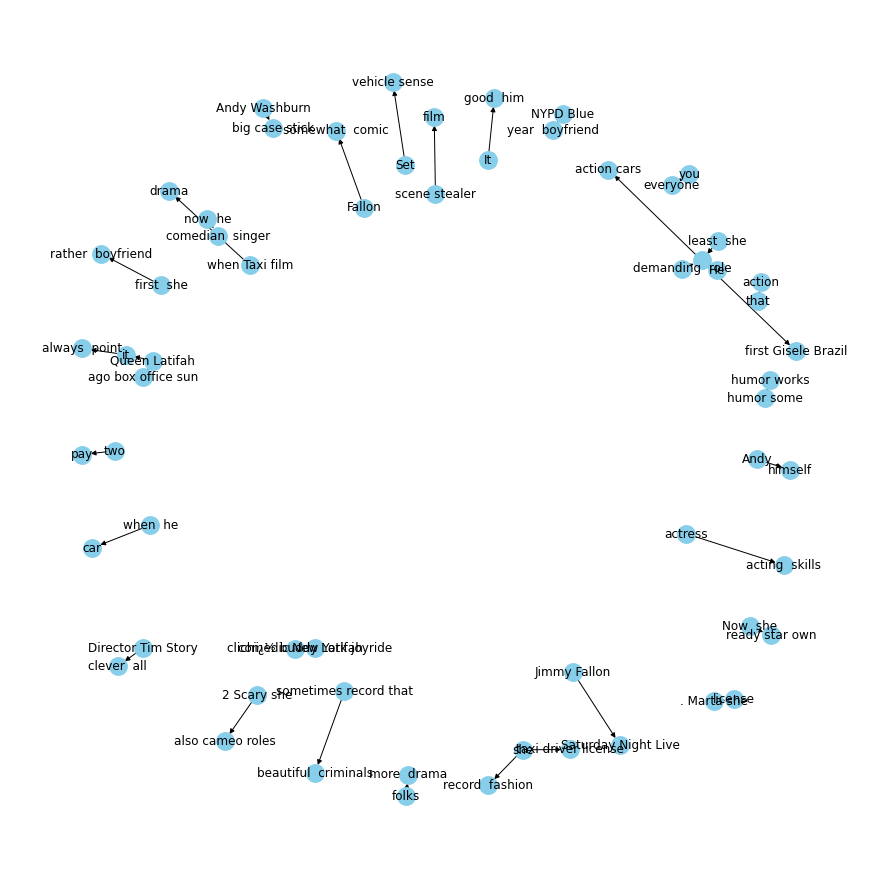

In [33]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        edge_cmap=plt.cm.Blues, 
        pos=pos)

plt.show()

# All Reviews

So far we have worked with one review. We can now roll out the same method to plot the knowledge graph for the 10 reviews collected for the chosen movie.

## Explore entities and relations

In [34]:
movie_reviews

0    "Bringing Down the House notwithstanding, Quee...
1    "After getting nominated for ""Chicago"" and m...
2    "Hollywood certainly does not, testament to th...
3    "How one likes ""Taxi"" has everything to do w...
4    "One of my favorite comedies to watch during t...
5    "Washburn is an undercover cop who, after yet ...
6    "Jimmy Fallon's big screen career may be over ...
7    "Gï¿½rard Pirï¿½s' 1998 film Taxi seems to hav...
8    "I'm actually old enough that when I hear the ...
9    "Queen Latifah handily walked away with the sh...
Name: Text, dtype: object

Conceptually, this is no different from working on one review, we simply join all the reviews for the movie into one large string.

In [35]:
all_movie_reviews = ' '.join(movie_reviews)

In [36]:
doc = nlp(all_movie_reviews)

In [37]:
doc_sents = [str(x) for x in doc.sents]

First sentence

In [38]:
doc_sents[0]

'"Bringing Down the House notwithstanding, Queen Latifah is usually fun to watch.'

Last sentence

In [39]:
doc_sents[-1]

'sure that every review/document has at least 500 words'

In [40]:
len(doc_sents)

274

In [41]:
entity_pairs = []

for i in tqdm(doc_sents):
  entity_pairs.append(get_entities(i))

100%|██████████| 274/274 [00:02<00:00, 104.84it/s]


In [42]:
relations = [get_relation(i) for i in tqdm(doc_sents)]

100%|██████████| 274/274 [00:02<00:00, 92.81it/s]


In [43]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [44]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [45]:
kg_df.shape

(247, 3)

In [46]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target", 
                            edge_attr=True, create_using=nx.MultiDiGraph())

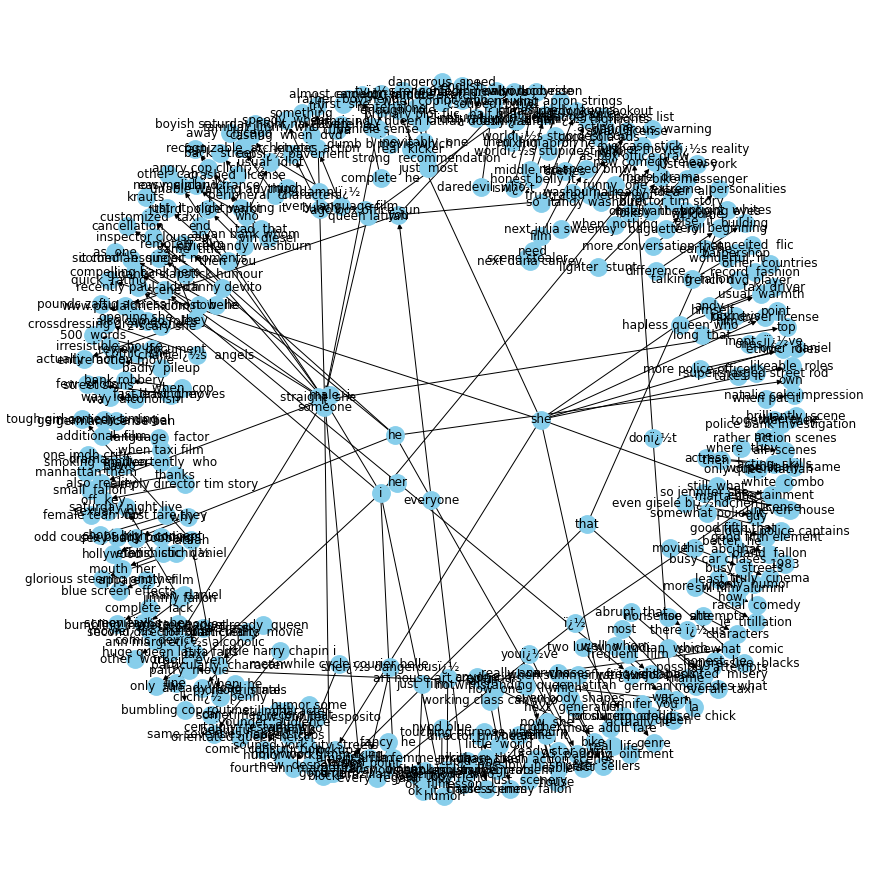

In [47]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        edge_cmap=plt.cm.Blues, 
        pos=pos)

plt.show()

## Interesting relations

There are several relations to explore in the plot from the previous section. We could choose to focus on some relations that we find are particularly interesting.

In [48]:
pd.Series(relations).value_counts()[:50]

is               45
's                9
has               6
be                6
know              5
have              5
are               5
plays             4
was               3
takes             3
think             3
commandeers       2
get               2
tells             2
go                2
notice            2
seem              2
seen              2
liked             2
knew              2
enjoyed           2
manages           2
seems             2
see               2
shown             2
deliver           1
lumbered with     1
goes              1
subside into      1
come              1
be honest         1
's over           1
hoped             1
was wrong         1
have high         1
provides          1
is OK             1
was terrific      1
reduces           1
becomes           1
With              1
all               1
cares little      1
matter            1
left              1
based on          1
appeal to         1
found             1
surprise          1
tire of           1


We could zoom in on interesting relations from the list above.

In [49]:
RELATION_TO_EXPLORE = 'know'

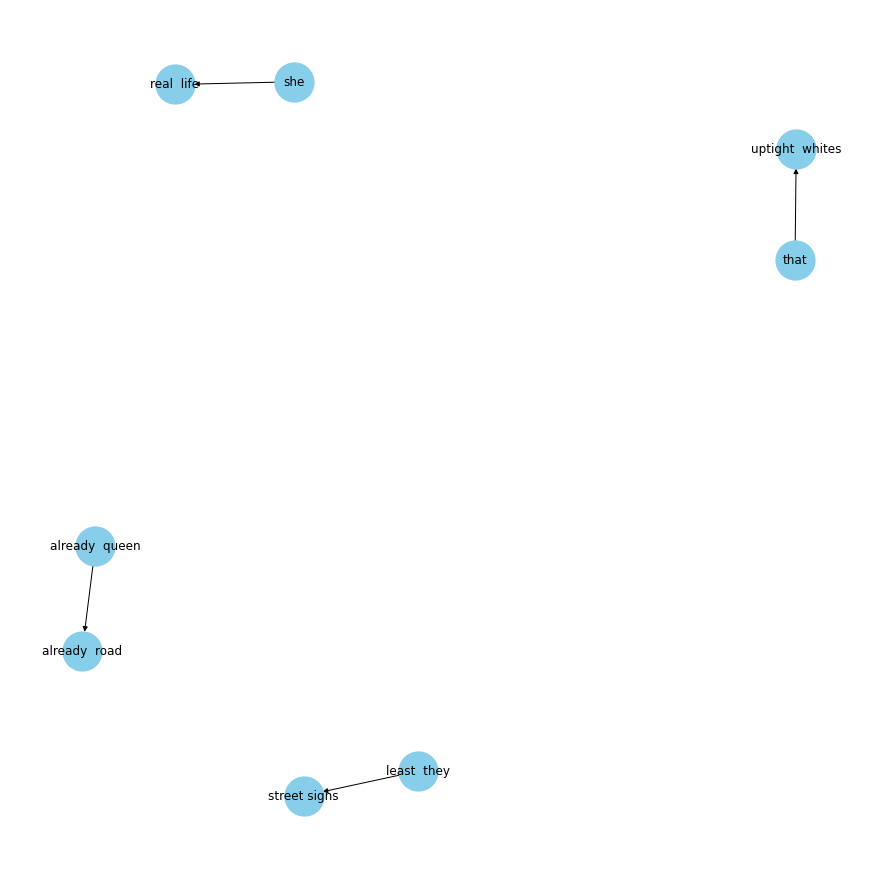

In [50]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == RELATION_TO_EXPLORE], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

## Interesting entities

Similary, we could zoom in on interesting entitites (say those identified from the manual ontology creation).

In [51]:
ENTITY_TO_EXPLORE = 'jimmy fallon'

In [52]:
entity_filter = (kg_df['source'] == ENTITY_TO_EXPLORE) | (kg_df['target'] == ENTITY_TO_EXPLORE)

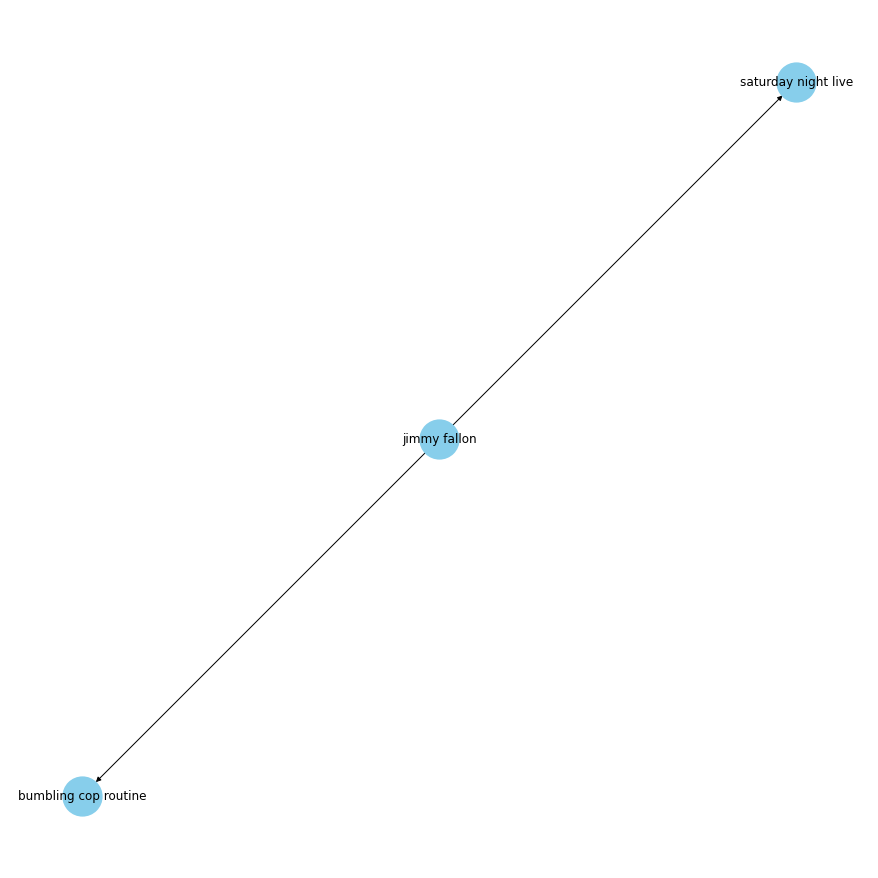

In [53]:
G = nx.from_pandas_edgelist(kg_df[entity_filter], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

# Next Steps

- Identify and merge equivalence classes in the entities extracted.
- Explore few interesting relations and entities.

# Reference

https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook